In [10]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from numba import jit,njit,cuda,uint32,uint8,f8,vectorize

pd.set_option('display.precision',2)
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(linewidth=160)
header_names = ['id','name','symbol','slug','num_market_pairs','date added','max_supply','circulating_supply','total_supply','platform_id','platform_name','platform_symbol','platform_slug','platform_token','cmc_rank','last_updated','price','volume_24h','percent_change_1h','percent_change_24h','percent_change_7d','percent_change_30d','percent_change_60d','percent_change_90d','market_cap','extracted_time','count']
my_data = pd.read_csv('all_crypto_half_hour.csv',names=header_names)
my_data = pd.DataFrame(my_data)

In [11]:
modified_data = my_data.drop(['platform_id','platform_name','platform_slug','platform_symbol','slug','platform_token','max_supply','id','extracted_time','count','date added','name','symbol','num_market_pairs','circulating_supply','total_supply','cmc_rank','last_updated','price','market_cap','volume_24h','percent_change_1h','percent_change_24h'],axis=1)
print(len(modified_data))
print(modified_data.isnull().sum()/len(modified_data))
modified_data = modified_data.dropna()

147500
percent_change_7d     0.00e+00
percent_change_30d    1.60e-03
percent_change_60d    3.66e-03
percent_change_90d    9.23e-03
dtype: float64


In [12]:
modified_data.describe()

,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d
count,146133.00,146133.00,146133.00,146133.00
mean,10.51,85.47,357.42,931.47
std,115.18,919.98,4110.32,10131.08
min,-74.25,-69.99,-75.04,-82.34
25%,-6.41,-1.28,28.31,87.02
50%,1.13,16.87,87.85,229.13
75%,15.27,62.32,225.24,537.41
max,14074.88,54575.46,248058.84,471389.96


In [13]:
modified_data = modified_data.loc[modified_data['percent_change_7d'] <= 200]
modified_data = modified_data.loc[modified_data['percent_change_30d'] <= 400 ]
modified_data = modified_data.loc[modified_data['percent_change_60d'] <= 600 ]
modified_data = modified_data.loc[modified_data['percent_change_90d'] <= 800 ]
modified_data.describe()

,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d
count,119729.00,119729.00,119729.00,119729.00
mean,4.20,24.52,94.28,218.43
std,20.05,47.28,105.44,194.18
min,-74.25,-69.99,-75.04,-82.34
25%,-6.03,-2.90,19.14,64.11
50%,0.42,11.66,63.14,170.17
75%,12.81,42.27,143.74,332.33
max,199.63,399.27,599.86,799.99


In [14]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(my_data.name)
my_data.name = labelencoder.transform(my_data.name)
new_data = pd.concat([my_data.name,my_data.percent_change_7d,my_data.percent_change_30d,
                      my_data.percent_change_60d,my_data.percent_change_90d],axis=1)
new_data.dropna(inplace=True)
new_data.head(100)
X_data = np.array(new_data.drop(['name'],1).astype(float))
Y_data = list(new_data.name)

C:\Users\braim\AppData\Local\Temp\ipykernel_16256\4030457017.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_data = np.array(new_data.drop(['name'],1).astype(float))


c:\users\braim\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1316: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


50.681435417301195


Text(0, 0.5, 'inertia values')

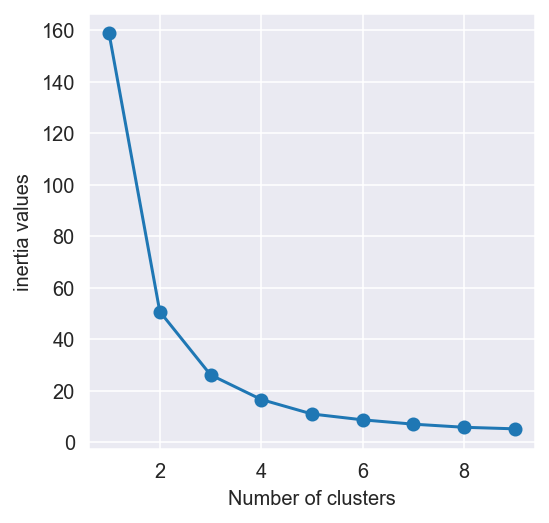

In [15]:
from sklearn.cluster import KMeans
X_data_scaled = MinMaxScaler().fit_transform(X_data)
Kmeans = KMeans(n_clusters=2,max_iter=600,algorithm='auto')
Kmeans.fit(X_data_scaled)
cluster_list = []
for index in range(1,10):
    kmeans = KMeans(n_clusters=index,init='k-means++')
    kmeans.fit(X_data_scaled)
    cluster_list.append(kmeans.inertia_)
frame = pd.DataFrame({'Clusters':range(1,10),'Cluster_list':cluster_list})
print(Kmeans.inertia_)
fig = plt.figure(figsize=(4,4))
plt.plot(frame['Clusters'],frame['Cluster_list'],marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('inertia values')

In [16]:
def clusters():
    k_means = KMeans(n_clusters=3)
    bitcoin_clusters = []
    non_bitcoin_cluster = []
    k_means.fit(X_data_scaled)
    correct = 0
    bitcoin_value: int = 0
    for i in range(len(X_data)):
        if i == 0:
            value_to_be_predicted = np.array(X_data[i].astype(float)).reshape(-1,len(X_data[i]))
            prediction = k_means.predict(value_to_be_predicted)
            bitcoin_value = prediction[0]
            bitcoin_clusters.append(Y_data[i])
        else:
            value_to_be_predicted = np.array(X_data[i].astype(float)).reshape(-1,len(X_data[i]))
            prediction = k_means.predict(value_to_be_predicted)
            if prediction[0] == bitcoin_value:
                bitcoin_clusters.append(Y_data[i])
            else:
                pass
    bitcoin_clusters = list(set(bitcoin_clusters))
    return bitcoin_clusters
bitcoin_clusters = clusters()

In [17]:
list_of_coin_names = ['BTC','ETH','LTC','USDT','XMR','XRP','ZEC','XLM','POT','BNB','USDC','SOL','LUNA','ADA',
                      'UST','BUSD','DOGE','AVAX','DOT','SHIB','WBTC']
selected_coins_array = []
coin_index = 0
data_coins = list(my_data['symbol'].unique())

for coin in list_of_coin_names:
    rows = my_data.loc[my_data['symbol']==coin]
    if data_coins.__contains__(coin) and bitcoin_clusters.__contains__(rows['name'].unique()):
        selected_coins_array.append(coin)
    else:
        continue
print(selected_coins_array)
your_coin = yf.download('BTC-USD',start='2018-01-01',end='2021-12-31')
print(your_coin.shape)
your_coin.head(20)
print(your_coin.isnull().sum()/len(your_coin))

['BTC', 'ETH', 'LTC', 'USDT', 'XMR', 'XRP', 'ZEC', 'XLM', 'BNB', 'USDC', 'SOL', 'LUNA', 'ADA', 'UST', 'BUSD', 'DOGE', 'AVAX', 'DOT', 'SHIB', 'WBTC']
[*********************100%***********************]  1 of 1 completed
(1461, 6)
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64


In [18]:
your_coin.tail(20)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-12,49354.86,50724.87,48725.85,50098.34,50098.34,21939223599
2021-12-13,50114.74,50205.00,45894.85,46737.48,46737.48,32166727776
2021-12-14,46709.82,48431.40,46424.50,46612.63,46612.63,34638619079
2021-12-15,48379.75,49473.96,46671.96,48896.72,48896.72,36541828520
2021-12-16,48900.46,49425.57,47529.88,47665.43,47665.43,27268150947
2021-12-17,47653.73,48004.89,45618.21,46202.14,46202.14,32902725329
2021-12-18,46219.25,47313.83,45598.44,46848.78,46848.78,26098292690
2021-12-19,46853.87,48089.66,46502.95,46707.02,46707.02,25154053861
2021-12-20,46707.06,47401.72,45579.81,46880.28,46880.28,30961902129


In [19]:
your_coin = your_coin.drop(['Adj Close'],axis=1)
your_coin.describe()

,Open,High,Low,Close,Volume
count,1461.00,1461.00,1461.00,1461.00,1.46e+03
mean,18356.29,18846.15,17812.71,18375.24,2.57e+10
std,17751.53,18246.61,17184.15,17760.30,2.12e+10
min,3236.27,3275.38,3191.30,3236.76,2.92e+09
25%,7116.55,7276.66,6898.28,7116.80,8.04e+09
50%,9471.21,9652.74,9263.07,9475.28,2.23e+10
75%,28841.57,29244.88,28201.99,29001.72,3.62e+10
max,67549.73,68789.62,66382.06,67566.83,3.51e+11


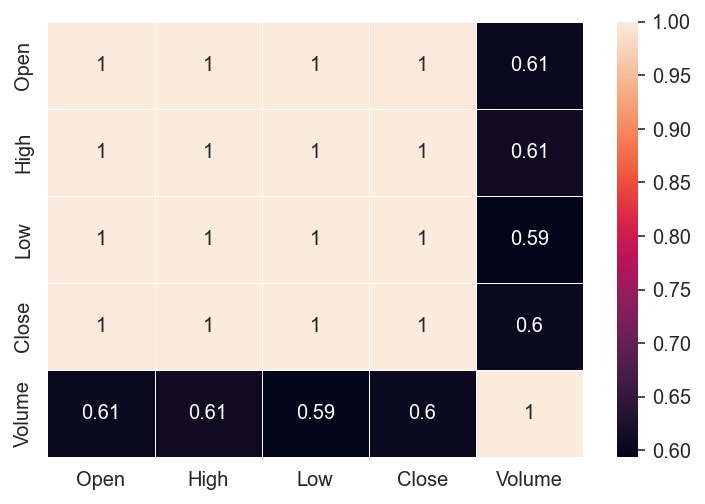

In [20]:
correlation = your_coin.corr()
sns.heatmap(correlation,annot=True,linewidths=.5)
plt.show()

In [21]:
your_coin = your_coin.drop(['High', 'Open', 'Close', 'Volume'], axis=1)

Low    1.32
dtype: float64


array([<AxesSubplot:title={'center':'Low'}>], dtype=object)

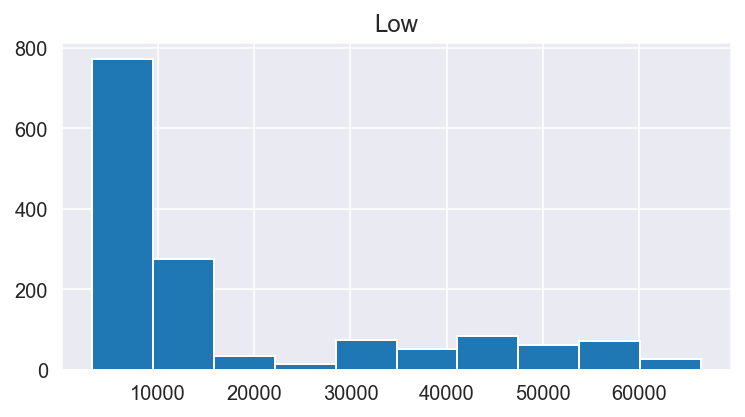

In [22]:
_,ax = plt.subplots(figsize=(6,3))
print(your_coin.skew())
your_coin.hist(ax=ax)

<AxesSubplot:>

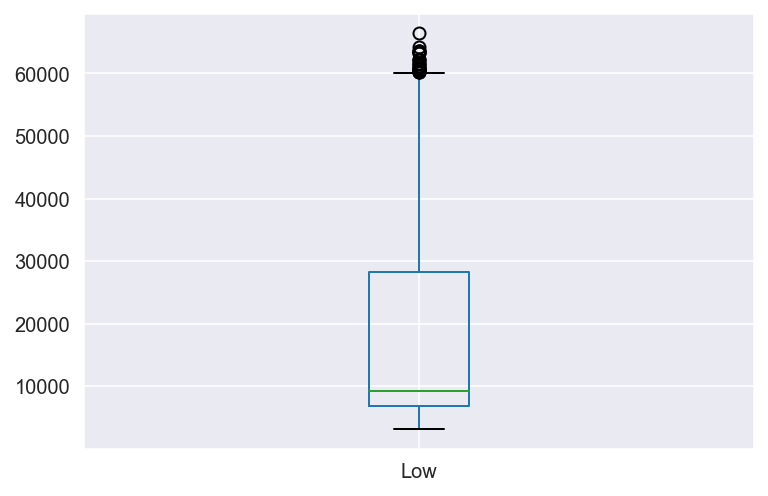

In [23]:
your_coin.boxplot()

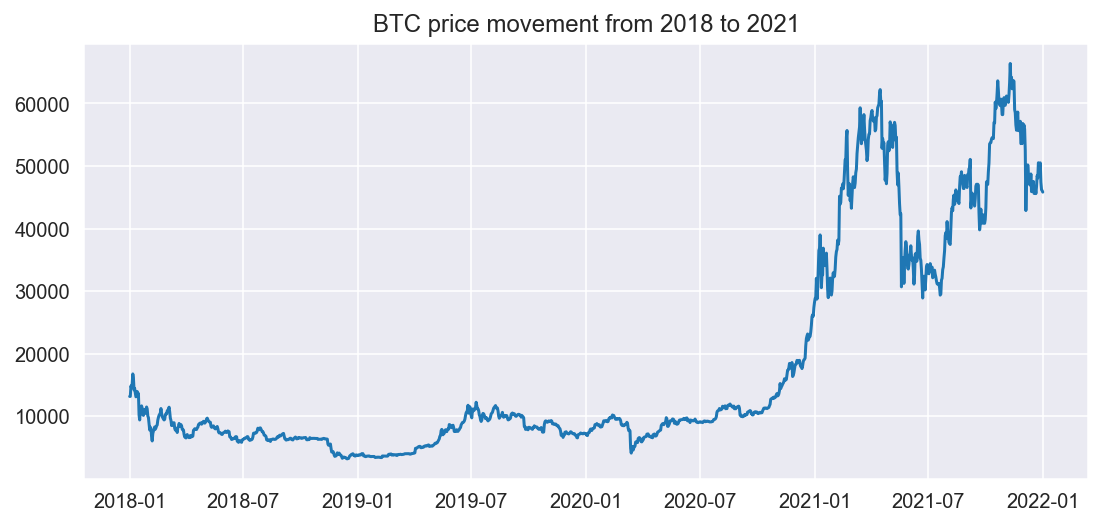

In [24]:
dates = pd.period_range(start='2018-01-01',end='2021-12-31', freq='D')
_,ax = plt.subplots(figsize=(9,4))
ax.plot(your_coin)
ax.set_title('BTC price movement from 2018 to 2021')
plt.show()

In [25]:
length = your_coin.size
X_train = np.array(your_coin.Low).reshape(-1,1)[:int(length * 0.8)]
X_test  = np.array(your_coin.Low).reshape(-1,1)[int(length * 0.8):]
print(X_train.shape)
print(X_test.shape)

(1168, 1)
(293, 1)


In [26]:
scaler = MinMaxScaler()
X_train = np.array(scaler.fit_transform(X_train)).reshape(-1,1)
X_test = np.array(scaler.fit_transform(X_test)).reshape(-1,1)
x_train = []
y_train = []
x_test = []
y_test = []
time_step = 30
for i in range(time_step,len(X_train)):
    x_train.append(X_train[i-time_step:i])
    y_train.append(X_train[i])
for i in range(time_step,len(X_test)):
    x_test.append(X_test[i-time_step:i])
    y_test.append(X_test[i])
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
x_train = x_train.reshape((len(x_train),time_step,1))
x_test = x_test.reshape((len(x_test),time_step,1))
print(y_train.shape)
x_train.shape

(1138, 1)


(1138, 30, 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_7 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_8 (LSTM)               (None, 30, 30)            7320      
                                                                 
 dense_3 (Dense)             (None, 30, 1)             31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 7s 139ms/step - loss: 0.1241 - accuracy: 9.7656e-04 - val_loss: 0.4766 - val_accuracy: 0.0000e+00
Epoch 2/30
35/35 [==============

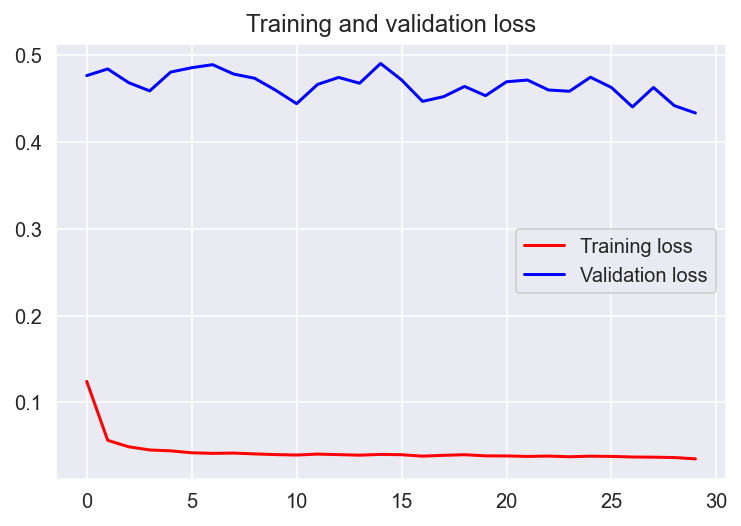

<Figure size 432x288 with 0 Axes>

In [43]:
from keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout
from keras.models import Sequential

model = Sequential()
model.add(LSTM(units=30,activation='sigmoid',return_sequences=True,input_shape=(x_train.shape[1],1),dropout=0.1))
model.add(LSTM(units=30,return_sequences=True,activation='sigmoid',dropout=0.1))
model.add(LSTM(units=30,return_sequences=True,activation='sigmoid',dropout=0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train,epochs=30,validation_split=0.1,batch_size=30,
                    verbose=1)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [28]:
def predict(model,data):
    y_pred = model.predict(data)
    y_pred = np.array(y_pred)[:, -1]
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [29]:
def plot(x,y,model_name,coin):
    plt.figure(figsize=(14,5))
    plt.plot(x, color = 'red', label = 'Real Bitcoin Price')
    plt.plot(y, color = 'green', label = 'Predicted Bitcoin Price')
    plt.title(f'{coin} Price Prediction using {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

9/9 [==============================] - 0s 20ms/step


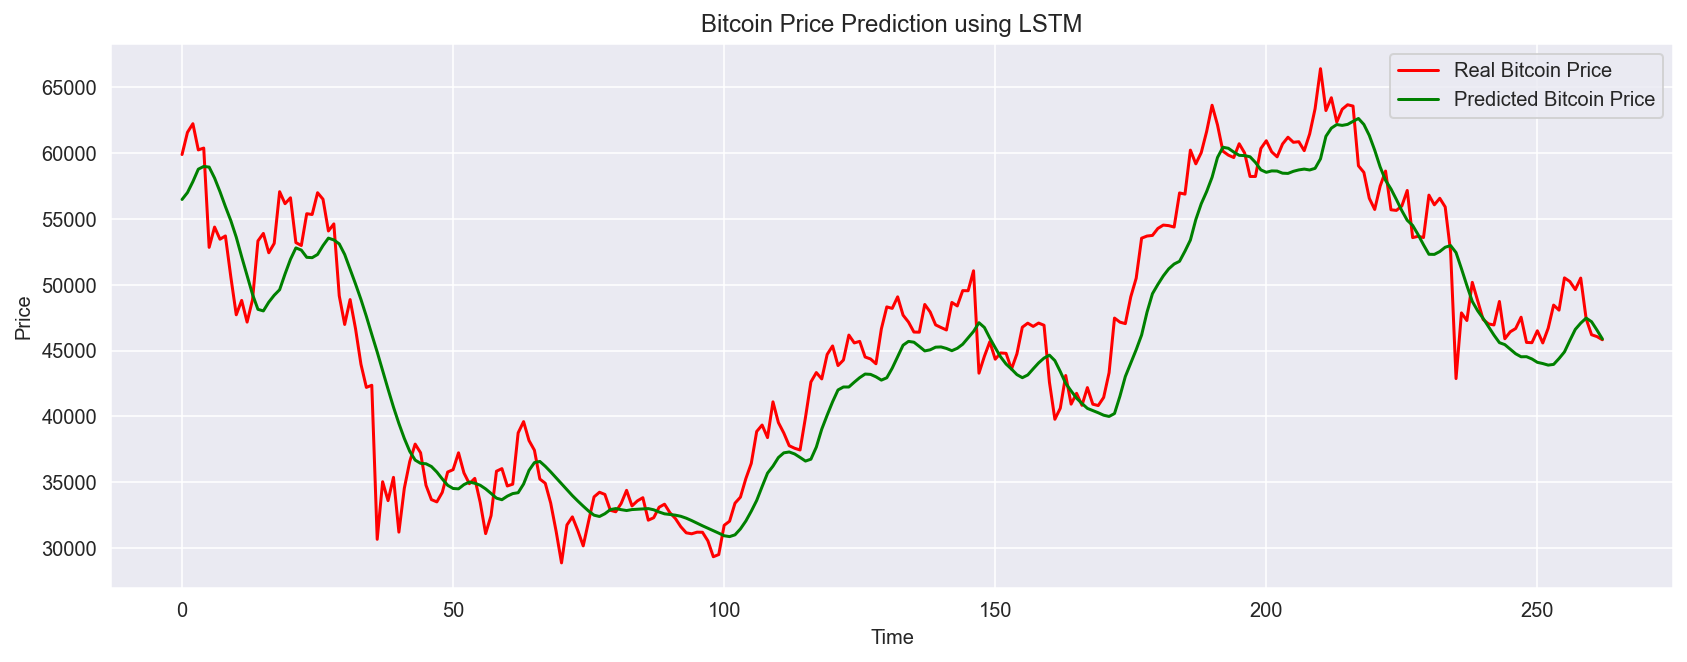

In [30]:
y_pred = predict(model=model,data=x_test)
y_test_lstm = scaler.inverse_transform(y_test)
plot(y_test_lstm,y_pred,'LSTM','Bitcoin')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 30)            2970      
                                                                 
 gru_1 (GRU)                 (None, 30, 60)            16560     
                                                                 
 gru_2 (GRU)                 (None, 30, 90)            41040     
                                                                 
 dense_1 (Dense)             (None, 30, 1)             91        
                                                                 
Total params: 60,661
Trainable params: 60,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
35/35 [==============================] - 8s 172ms/step - loss: 0.0429 - accuracy: 9.7656e-04 - val_loss: 0.4059 - val_accuracy: 0.0000e+00
Epoch 2/20
35/35 [==============

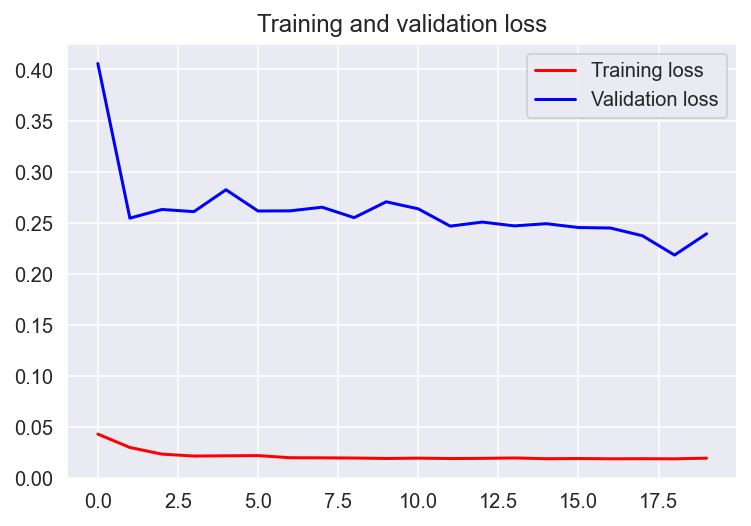

<Figure size 432x288 with 0 Axes>

In [31]:
model_gru = Sequential()
model_gru.add(GRU(units=30,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1),dropout=0.1))
model_gru.add(GRU(units=60,return_sequences=True,activation='relu',dropout=0.1))
model_gru.add(GRU(units=90,return_sequences=True,activation='relu',dropout=0.1))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_absolute_error',metrics=['accuracy'])
model_gru.summary()
history_gru = model_gru.fit(x_train,y_train,epochs=20,validation_split=0.1,batch_size=30,verbose=1)
loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']
epochs = range(len(loss_gru))
plt.plot(epochs, loss_gru, 'r', label='Training loss')
plt.plot(epochs, val_loss_gru, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

9/9 [==============================] - 0s 26ms/step


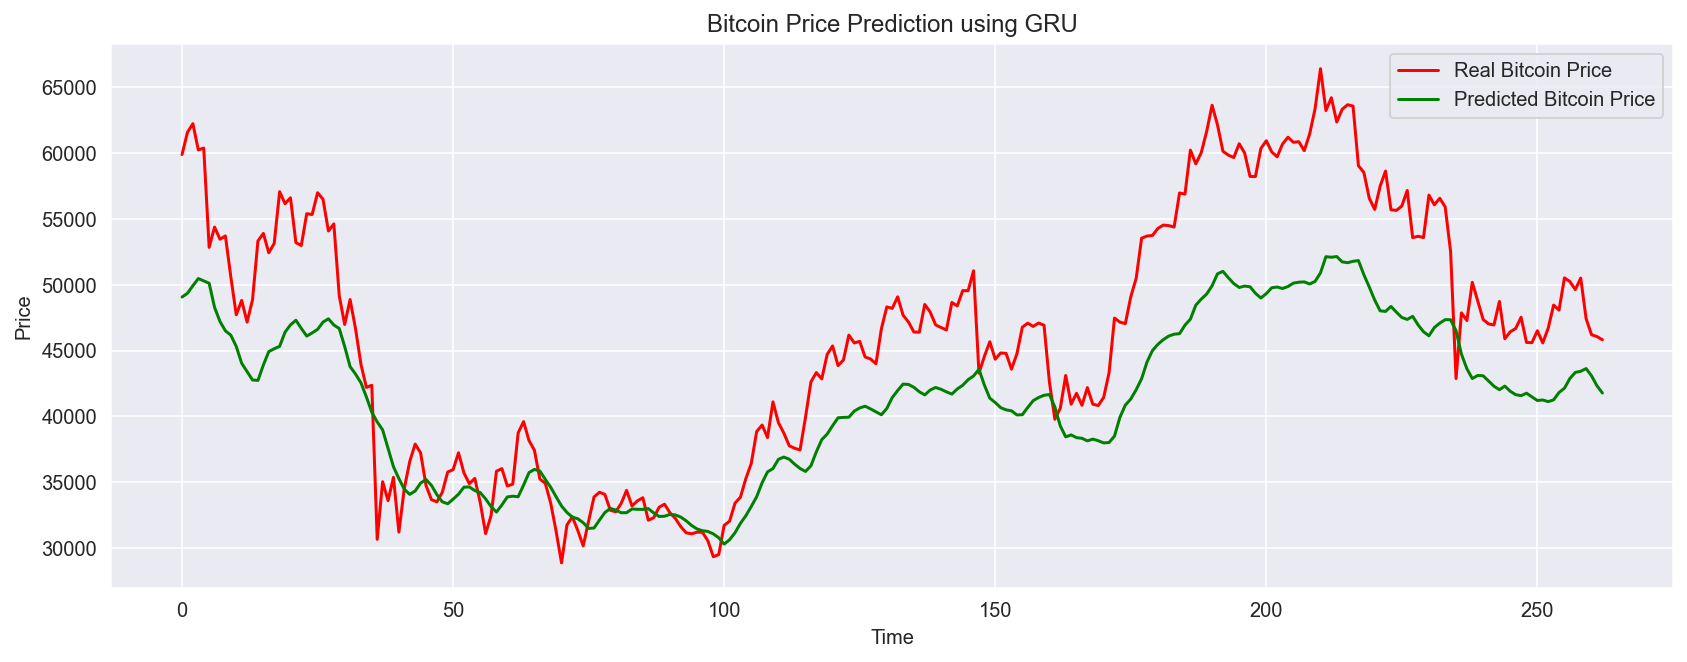

In [32]:
y_pred_gru = predict(model=model_gru,data=x_test)
y_test_gru = scaler.inverse_transform(y_test)
plot(y_test_gru,y_pred_gru,'GRU','Bitcoin')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 60)           7680      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 60)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 120)          58080     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 120)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 180)          151920    
 nal)                                                            
                                                      

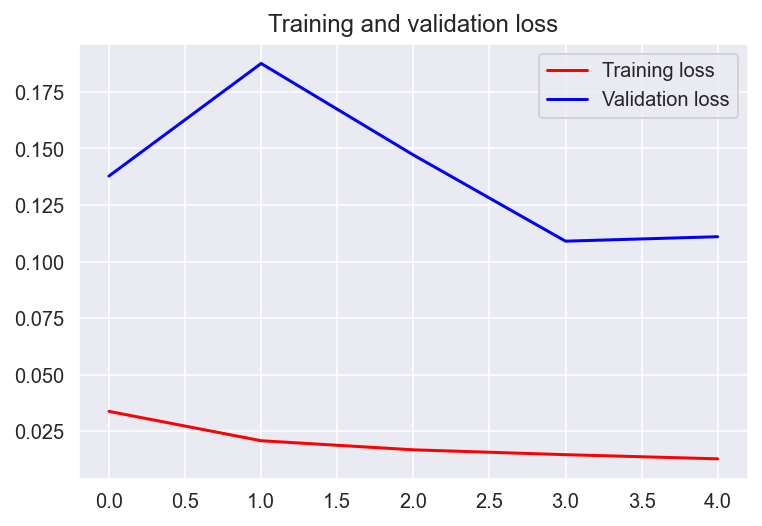

<Figure size 432x288 with 0 Axes>

In [33]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=30,activation='relu',return_sequences=True),input_shape=(x_train.shape[1],1)))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Bidirectional(LSTM(units=60,return_sequences=True,activation='relu')))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Bidirectional(LSTM(units=90,return_sequences=True,activation='relu')))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Dense(units=1))
model_bilstm.compile(optimizer='adam', loss='mean_absolute_error',metrics=['accuracy'])
model_bilstm.summary()
history_bilstm = model_bilstm.fit(x_train,y_train,epochs=5,validation_split=0.1,batch_size=30,verbose=1)
loss_bilstm = history_bilstm.history['loss']
val_loss_bilstm = history_bilstm.history['val_loss']
epochs = range(len(loss_bilstm))
plt.plot(epochs, loss_bilstm, 'r', label='Training loss')
plt.plot(epochs, val_loss_bilstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
model_random_forest = RandomForestRegressor(n_estimators=500,max_depth=50, criterion='mae')
random_forest_train = x_train.reshape(len(x_train),30)
random_forest_test = x_test.reshape(len(x_test),30)
model_random_forest.fit(random_forest_train,y_train)
predicted_data = model_random_forest.predict(random_forest_test)
print(model_random_forest.get_params())
print('Your mean_absolute_error is %',mean_absolute_error(y_test,predicted_data))

C:\Users\braim\AppData\Local\Temp\ipykernel_16256\1797462856.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_random_forest.fit(random_forest_train,y_train)
c:\users\braim\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mae', 'max_depth': 50, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Your mean_absolute_error is % 0.06399354735296367


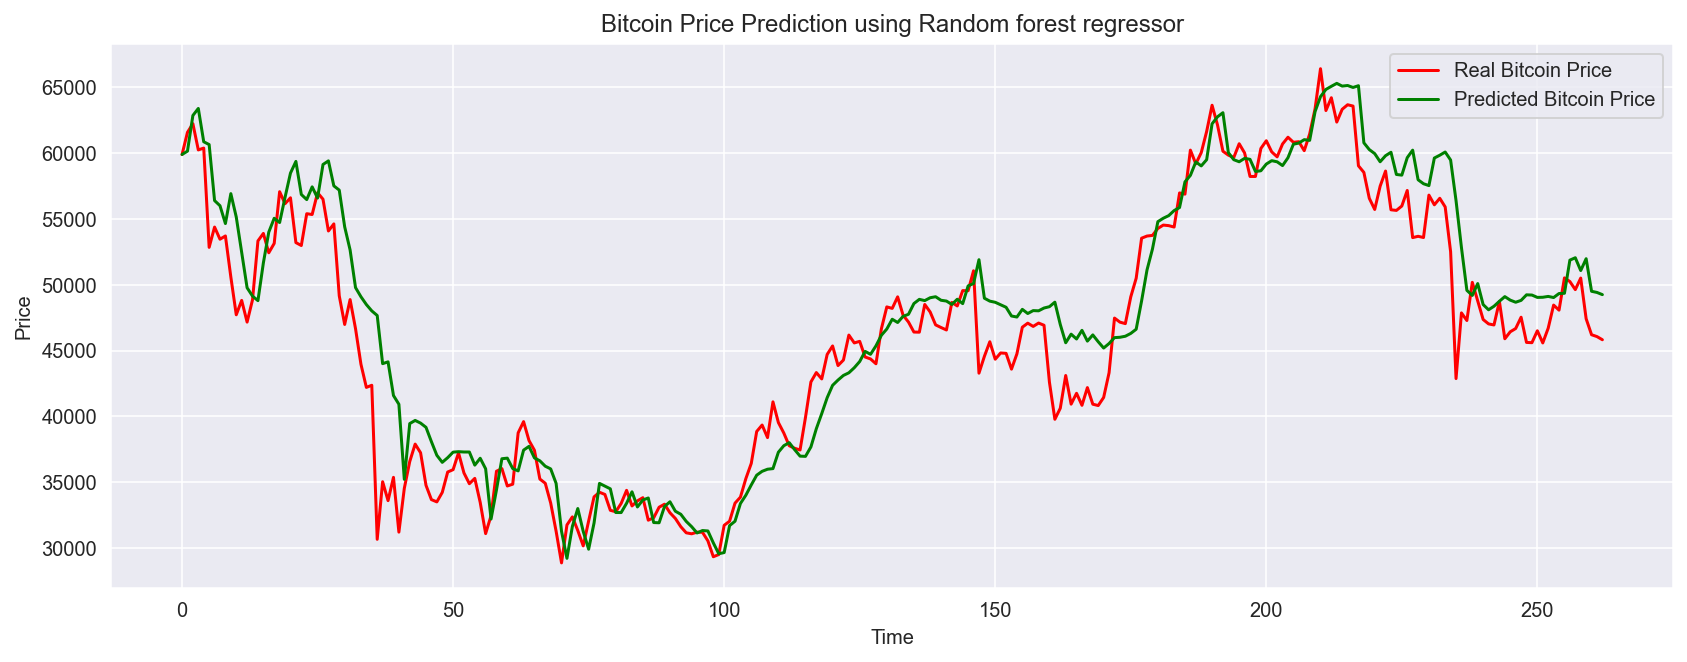

In [35]:
plot(scaler.inverse_transform(y_test),scaler.inverse_transform(np.array(predicted_data).reshape(-1,1)),
     'Random forest regressor','Bitcoin')

In [36]:
eth_data = yf.download('ETH-USD',start='2022-01-01',end='2022-02-28')
eth_data = eth_data['Low']
eth_x_test = []
eth_y_test = []
for i in range(time_step,len(eth_data)):
    eth_x_test.append(eth_data[i-time_step:i])
    eth_y_test.append(eth_data[i])
eth_x_test, eth_y_test = np.array(eth_x_test).reshape(len(eth_x_test),30), np.array(eth_y_test).reshape(-1,1)
eth_x_test, eth_y_test = np.array(scaler.fit_transform(eth_x_test)), np.array(scaler.fit_transform(eth_y_test))
predictions = model_random_forest.predict(eth_x_test)
print('Your mean absolute error is %',mean_absolute_error(eth_y_test,predictions))

[*********************100%***********************]  1 of 1 completed
Your mean absolute error is % 0.15472801859575702


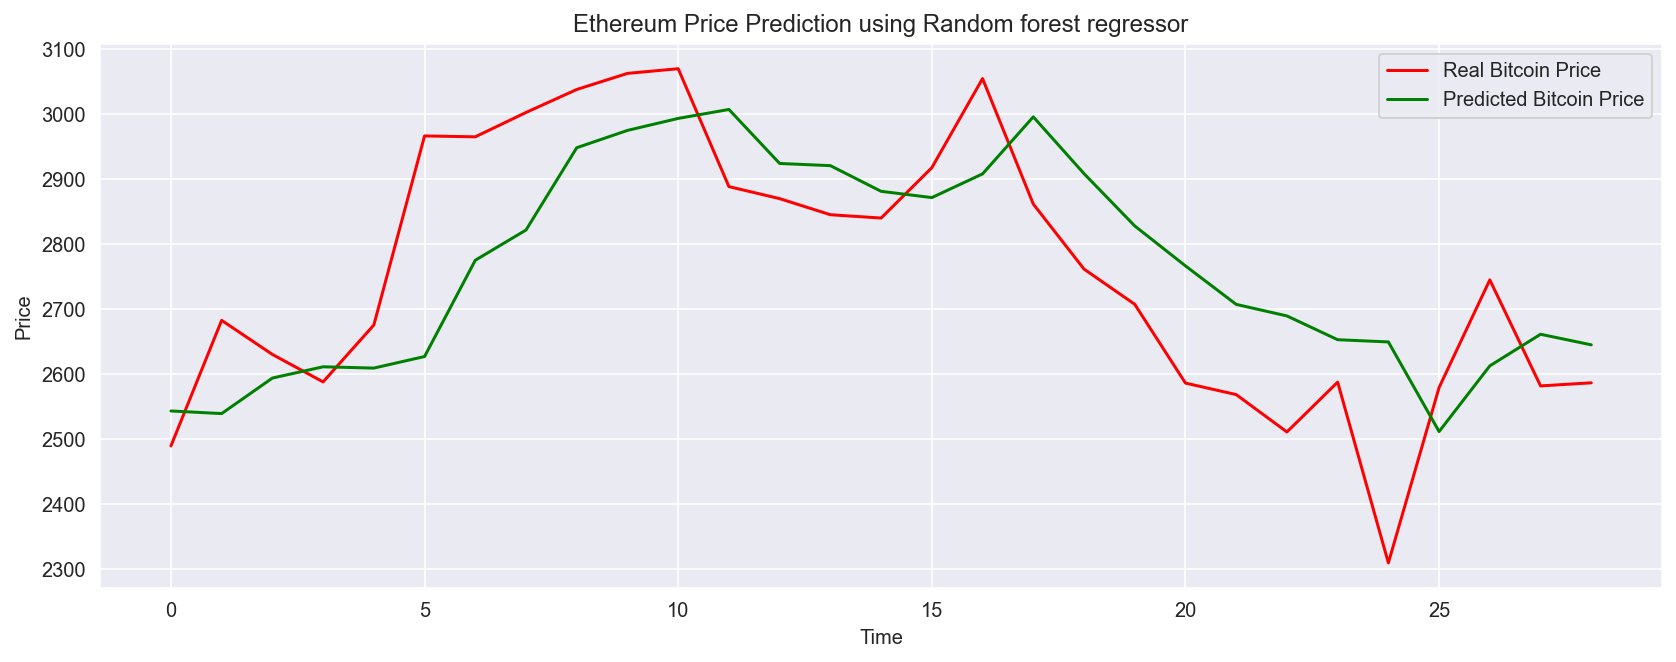

In [37]:
plot(scaler.inverse_transform(eth_y_test),scaler.inverse_transform(np.array(predictions).reshape(-1,1)),
     'Random forest regressor','Ethereum')

In [38]:
btc_data = yf.download('BTC-USD',start='2022-01-01',end='2022-02-28')
btc_data = btc_data['Low']
btc_x_test = []
btc_y_test = []
for i in range(time_step,len(btc_data)):
    btc_x_test.append(btc_data[i-time_step:i])
    btc_y_test.append(btc_data[i])
btc_x_test, btc_y_test = np.array(btc_x_test).reshape(len(btc_x_test),30), np.array(btc_y_test).reshape(-1,1)
btc_x_test, btc_y_test= np.array(scaler.fit_transform(btc_x_test)), np.array(scaler.fit_transform(btc_y_test))
predictions_btc = np.array(model_random_forest.predict(btc_x_test)).reshape(-1,1)
print('Your mean_absolute_error is %',mean_absolute_error(btc_y_test,predictions_btc))

[*********************100%***********************]  1 of 1 completed
Your mean_absolute_error is % 0.155566750905988


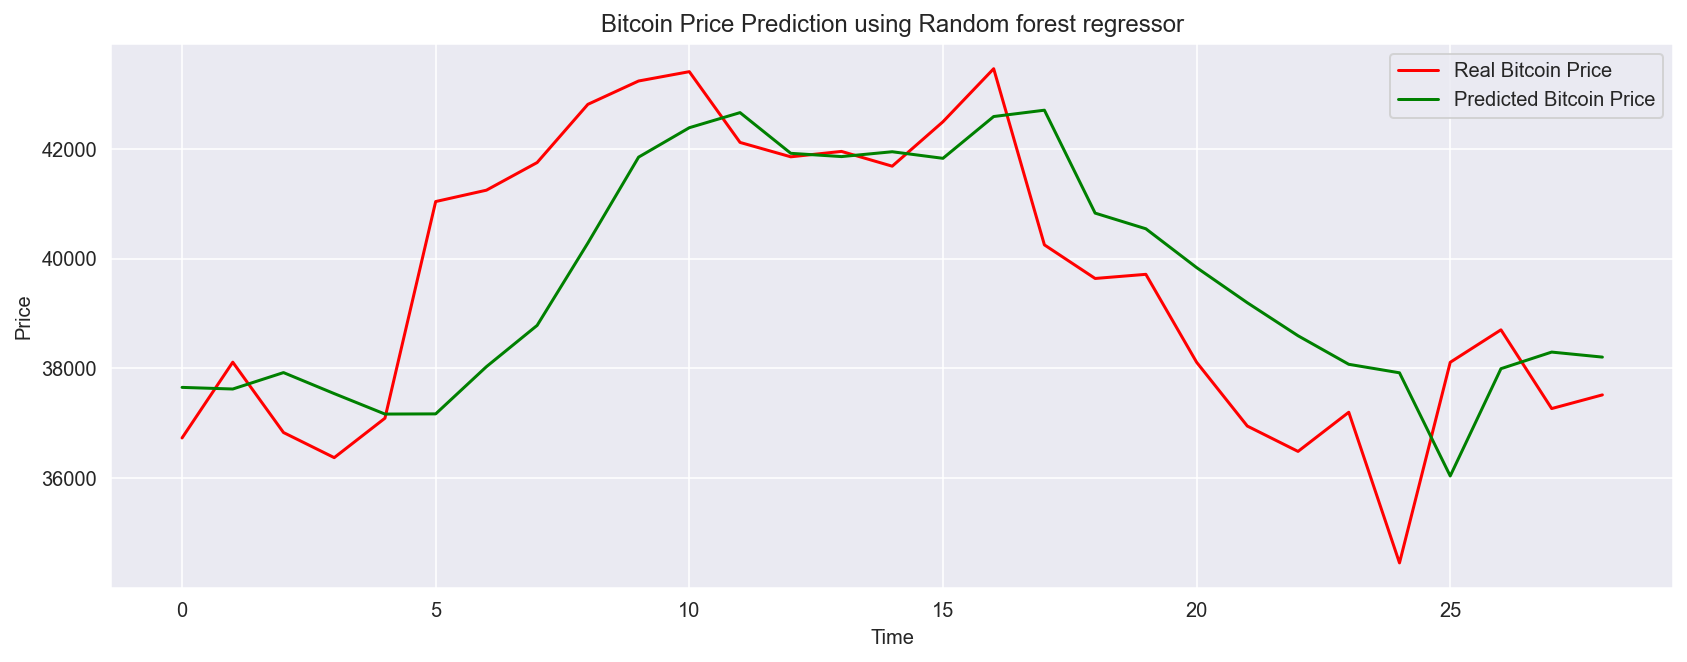

In [39]:
plot(scaler.inverse_transform(btc_y_test),scaler.inverse_transform(predictions_btc), 'Random forest regressor','Bitcoin')

In [40]:
btc_x_test_lstm = btc_x_test.reshape((len(btc_x_test),30,1))
predictions_lstm_btc = model.predict(btc_x_test_lstm)
predictions_lstm_btc = np.array(predictions_lstm_btc[:, -1])
print('Your mean absolute error is %',mean_absolute_error(btc_y_test,predictions_lstm_btc))

1/1 [==============================] - 0s 31ms/step
Your mean absolute error is % 0.19431602269945872


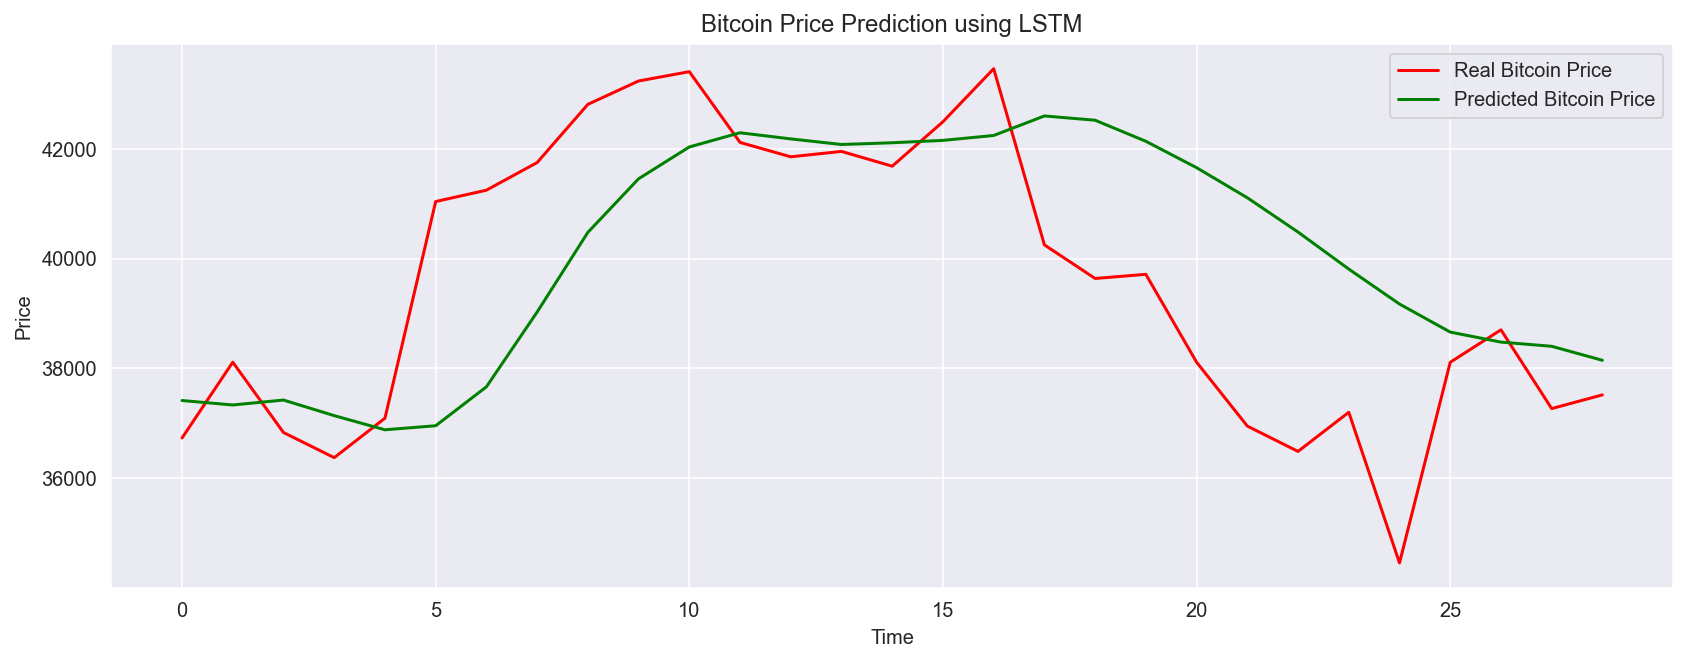

In [41]:
plot(scaler.inverse_transform(btc_y_test),scaler.inverse_transform(predictions_lstm_btc), 'LSTM', 'Bitcoin')

In [42]:
import joblib as jb
random_forest_model = jb.dump(model_random_forest,'random_forest_model.sav')